In [6]:
import numpy as np

# True parameter values (alpha, beta)
alpha = 1.0
beta = 0.1

# Initial population of rabbits and foxes
X0 = [10.0, 5.0]
size = 100 # Size of data
time = 15 # Time lapse
t = np.linspace(0, time, size)

# Lotka-Volterra equations
def dX_dt(X, t, a = alpha, b = beta):
    'Return the growth rate of fox and rabbit populations.'
    return np.array([
        a * X[0] - b * X[0] * X[1],
        -1.5 * X[1] + 0.75 * b * X[0] * X[1]
    ])

The solution to this system of ODEs might be written:



In [7]:
from scipy.integrate import odeint

def competition_model(params, x = None):
    a, b, _ = params
    'Simulator function (an ordinary differential equation to be integrated)'
    return odeint(dX_dt, y0 = X0, t = t, rtol = 0.01, args = (a, b))

We generate some synthetic, "observed" data as:



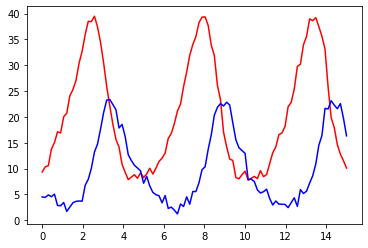

In [13]:
import matplotlib.pyplot as plt
a = alpha
b=beta
# Observed data (with added random noise)
data = competition_model(
    params = (a, b, None)) + np.random.normal(size = (size, 2))
plt.plot(t, data[:, 0], 'r-', label = 'Rabbits')
plt.plot(t, data[:, 1], 'b-', label = 'Foxes')

In [14]:
import theano.tensor as tt

class BlackBoxLikelihood(tt.Op):
    itypes = [tt.dvector] # Expects a vector of parameter values when called
    otypes = [tt.dscalar] # Outputs a single scalar value (the log likelihood)

    def __init__(self, model, observed, x):
        '''
        Parameters
        ----------
        model : Callable
            An arbitrary "black box" function that takes two arguments: the
            model parameters ("params") and the forcing data ("x")
        observed : numpy.ndarray
            The "observed" data that our log-likelihood function takes in
        x:
            The forcing data (input drivers) that our model requires
        '''
        self.model = model
        self.observed = observed
        self.x = x

    def loglik(self, params, x, observed):
        # The root-mean squared error (RMSE)
        predicted = self.model(params, x)
        return -np.sqrt(np.nanmean((predicted - observed) ** 2))

    def perform(self, node, inputs, outputs):
        # The method that is used when calling the Op
        (params,) = inputs
        logl = self.loglik(params, self.x, self.observed)
        outputs[0][0] = np.array(logl) # Output the log-likelihood

ModuleNotFoundError: No module named 'theano'